# Rede Neural Artificial - Regressão Linear MUltipla

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers

%matplotlib inline

## Obter os dados

In [2]:
data = pd.read_csv("games.csv")

In [3]:
# NA_Sales: Vendas na America do Norte
# Other_Sales: Vendas em outros locais
# Global_Sales: Vendas totais
# Critic_Score: Critica média do jogo de 0 a 100. Nota dada pelos sites
# Critic_Count: Número de criticas consideradas para obter o Critic_Score
# User_Score: Nota dada pelo utilizador
# User_Count: Numero de utilizadores que avaliaram o jogo. Utilizado para calcular o User_Score
# Rating: Classificação do jogo (maiores de 10 anos, maiores de 18 anos, etc...)


data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


## Pré-Processamento: Remover colunas que não têm influência no modelo

In [4]:
# Existem 223 jogos com nomes diferentes. Como o númemro de linhas do modelo final vai passar para 258 vai-se apagar esta
# coluna porque tem uma variabilidade muito grande em relação ao número de linhas.

data["Name"].value_counts()

Need for Speed: Most Wanted                                     12
LEGO Marvel Super Heroes                                         9
Ratatouille                                                      9
Madden NFL 07                                                    9
FIFA 14                                                          9
FIFA 15                                                          8
Madden NFL 08                                                    8
The LEGO Movie Videogame                                         8
LEGO Star Wars II: The Original Trilogy                          8
Monopoly                                                         8
LEGO Jurassic World                                              8
LEGO The Hobbit                                                  8
Angry Birds Star Wars                                            8
Lego Batman 3: Beyond Gotham                                     8
Terraria                                                      

In [5]:
# Como se quer fazer as previsões das vendas de jogos para a America do Norte, Europa e Japão, existem algumas variaveis que não
# são necessárias.
# Apagou-se a variavel Developer porque a variavel Publisher é identica.

# Se o objectivo fosse prever as vendas totais(Global_Sales) poderia-se utilizar uma rede neural para regressão linear simples
# e como variavael de saida a Global_Sales.

data = data.drop(["Other_Sales", "Global_Sales", "Developer", "Name"], axis=1)

In [6]:
data.head(2)

,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,76.0,51.0,8,322.0,E
1,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,NaN,NaN,NaN,NaN,NaN


## Pré-Processamento: Tratamento de Valores Ausentes

In [7]:
# Soma dos valores nulos por coluna
data.isnull().sum()

Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Rating             6769
dtype: int64

In [8]:
# percentagem dos valores nulos por coluna
percent = (data.isnull().sum()/len(data))*100
sorted(percent, reverse=True)[:10]

[54.60254799928226,
 51.33082122136492,
 51.33082122136492,
 40.486871224355525,
 40.0980919911478,
 1.60894790358275,
 0.32298582451103536,
 0.011962437944853162,
 0.0,
 0.0]

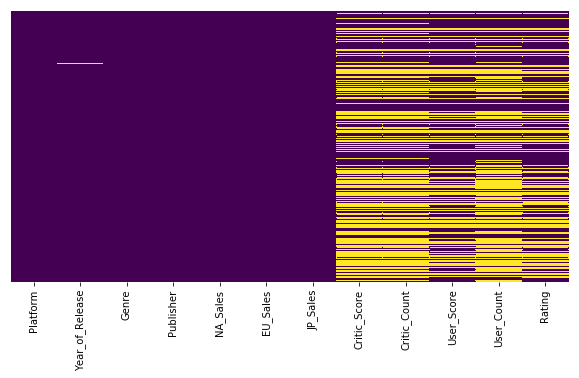

In [9]:
# Visualização dos valores nulos
plt.figure(figsize=(10,5))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap="viridis")

In [10]:
# Optou-se por apagar os valores ausentes. Poderia-se substituir-se pela média da coluna mas isso poderia ter influência no 
# desvio padrão do modelo porque são muitos valores ausentes.

# axis=0, apagar por linha

data = data.dropna(axis=0)

In [11]:
# O numero de linhas diminuiu substancialmente.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6825 entries, 0 to 16706
Data columns (total 12 columns):
Platform           6825 non-null object
Year_of_Release    6825 non-null float64
Genre              6825 non-null object
Publisher          6825 non-null object
NA_Sales           6825 non-null float64
EU_Sales           6825 non-null float64
JP_Sales           6825 non-null float64
Critic_Score       6825 non-null float64
Critic_Count       6825 non-null float64
User_Score         6825 non-null object
User_Count         6825 non-null float64
Rating             6825 non-null object
dtypes: float64(7), object(5)
memory usage: 693.2+ KB


## Pré-Processamento: Tratamento de Valores Inconsistentes

In [12]:
# Apagar as vendas inferiores a 1 para a America do Norte e Europa pora o modelo não ter uma correlação baixa(erro alto).
# Para o Japão não se fez o mesmo porque diminuiria substancialmente o numero de dados necessarios para fazer a modelação do
# algoritmo.

len(data[data["NA_Sales"] < 1])

6233

In [13]:
len(data[data["EU_Sales"] < 1])

6486

In [14]:
data = data[(data["NA_Sales"]>1) & (data["EU_Sales"]>1)]

In [15]:
# O dataset passou para apenas 258 linhas.
len(data)

258

In [22]:
# teste para ver se o novo dataframe não contem os valores inconsistentes
data[data["NA_Sales"] < 1]

,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating


In [23]:
# teste para ver se o novo dataframe não contem os valores inconsistentes
data[data["EU_Sales"] < 1]

,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating


## Divisão Variaveis Entrada - Variaveis Saida 

In [24]:
data.head(2)

,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,76.0,51.0,8,322.0,E
2,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,82.0,73.0,8.3,709.0,E


In [25]:
# X - variáveis usadas para modelar o modelo
X = data.drop(["NA_Sales", "EU_Sales", "JP_Sales"], axis=1)
X.head(1)

,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii,2006.0,Sports,Nintendo,76.0,51.0,8,322.0,E


In [26]:
# y_NA - variavel que se pretende avaliar
y_NA = data["NA_Sales"]
y_NA.head(1)

0    41.36
Name: NA_Sales, dtype: float64

In [27]:
# y_EU - variavel que se pretende avaliar
y_EU = data["EU_Sales"]
y_EU.head(1)

0    28.96
Name: EU_Sales, dtype: float64

In [28]:
# y_JP - variavel que se pretende avaliar
y_JP = data["JP_Sales"]
y_JP.head(1)

0    3.77
Name: JP_Sales, dtype: float64

## Pré-processamento - label encoder (Transformação de variaveis categóricas em quantitativas)

In [29]:
from sklearn.preprocessing import LabelEncoder

In [30]:
enc = LabelEncoder()

In [31]:
# Transformar as variáveis categoricas em numéricas para que a rede neural as compreenda. As redes neurais só trabalham com
# dados númericos.
X["Platform"] = enc.fit_transform(X["Platform"])
X["Genre"] = enc.fit_transform(X["Genre"])
X["Publisher"] = enc.fit_transform(X["Publisher"])
X["Rating"] = enc.fit_transform(X["Rating"])

In [32]:
X.head(1)

,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,10,2006.0,10,13,76.0,51.0,8,322.0,0


## Pré-processamento - one hot encoder

In [33]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [34]:
X["Genre"].value_counts()

0     74
8     55
7     23
6     23
3     23
4     21
10    14
9     11
2      7
1      4
5      2
11     1
Name: Genre, dtype: int64

In [35]:
# https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f
# https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

# https://www.quora.com/Minmaxscaler-vs-Standardscaler-Are-there-any-specific-rules-to-use-one-over-the-other-for-a-particular-application
# https://datascience.stackexchange.com/questions/45900/when-to-use-standard-scaler-and-when-normalizer
# https://jovianlin.io/feature-scaling/

# Ao se utilizar apenas o labelencoder o algoritmo assume que quanto maior for o valor, melhor é a categoria. Assume que existe
# uma ordenação(7 melhor do que 6) dos valores da categoria.

# Por exemplo na coluna Genre o algoritmo assumiria que o Genre 6 seria melhor que o Genre 1.
# Se o algoritmo calcular a média entre o Genre 6 e Genre 0  (6+0)/2=3. A média  seria o Genre 3. 
# O que não faz sentido. Por isso deve-se utilizar o one-hot-encoding para transformar a coluna inicial em variáveis(colunas) 
# binárias. Tambem se pode utilizar o pd.get_dummies()

# Genre 0: 1 0 0 0 0 0 0
# Genre 1: 0 1 0 0 0 0 0
# ....
# Genre 6: 0 0 0 0 0 1 0
# Genre 7: 0 0 0 0 0 0 1
# ....

In [36]:
# X["Platform"] = X[:,0]
# X["Genre"] = X[:,2]
# X["Publisher"] = X[:,3]
# X["Rating"] = X[:,8]

# No OneHotEncoder()
# O categories é utilizado quando se deseja passar manualmente o nome das categorias, por sua vez, no categorical_features é 
# passado um array de índices.

# Variaveis a transformar em dummies
# remainder: manter as colunas que não são transformadas
# oneHotEncoder: transformar as varieveis em dummies
# colunas a transformar: [0,2,3,8]

transformer = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [0,2,3,8])], remainder='passthrough')

In [37]:
X = transformer.fit_transform(X).toarray()

C:\Users\Bruno\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [38]:
# Novo dataframe com as variaveis dummies
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2006.0,76.0,51.0,8.0,322.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2008.0,82.0,73.0,8.3,709.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2009.0,80.0,73.0,8.0,192.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2006.0,89.0,65.0,8.5,431.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2006.0,58.0,41.0,6.6,129.0


## Divisão Treino-Teste 

In [39]:
from sklearn.model_selection import train_test_split

In [43]:
X.head(1)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2006.0,76.0,51.0,8.0,322.0


In [47]:
# Dataframe  com as 3 variaveis de saida
y = pd.DataFrame({"y_NA":np.array(y_NA), "y_EU":np.array(y_EU), "y_JP":np.array(y_JP)})
y.head(1)

,y_NA,y_EU,y_JP
0,41.36,28.96,3.77


In [48]:
# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [51]:
# Variavies de saida de traino
y_train.head(2)

,y_NA,y_EU,y_JP
93,2.45,2.01,0.87
98,1.88,1.47,2.02


In [53]:
# Variaveis de saida de teste
y_test.head(2)

,y_NA,y_EU,y_JP
42,3.88,3.42,1.69
231,1.75,1.01,0.00


## Modelo Artificial Neural Network

In [54]:
# Deveria ser feito a normalização das variaveis porque existem variaveis dominantes.

In [58]:
# Não se utiliza o modelo Sequential porque as camadas de saida não são definidas umas após a outras e sim após a ultima camada
# oculta

# dense - camadas fully conected, cada neuronio esta conectado a todos os neuronios da camada seguinte

# Camada de entrda
# Camada Input e shape=61 porque é o númemro de variaveis de entrada.

# 1ª Camada Oculta
# Neuronios: normalmente escolhe-se o número de neuronios igual ao número de variaveis de entrada mais o número de variaveis de 
# saida divididos por 2 ((61+3)/2=32) para começar a modelar a rede. 
# Função de Activação: Normalmente escolhe-se a reLu para deep learning porque obtem-se melhores resultados do que com uma
# função sigmoide ou tangente hiperbolica (Neste caso escolheu-se a sigmoide porque é a que obtem melhores resultados). 
# Como não se está a trabalhar com o modelo sequeêncial(em que uma cadama é definida apos outra camada) tem-se de definir qual 
# a ordem das camadas(a 1ª Camada Oculta é colocada depois da camada de entrada).

# 2ª Camada Oculta
# Na segunda camada oculta em geral coloca-se a mesma quantidade de neurónios do que na primeira.
# Como não se está a trabalhar com o modelo sequeêncial(em que uma cadama é definida apos outra camada) tem-se de definir qual 
# a ordem das camadas(a 2ª Camada Oculta é colocada depois da 1ª camada de oculta).

# Camada de Saida 1 (como se tem 3 variaveis de saida são necessárias 3 camadas de saida)
# Neuronios: Igual a 1. 1 saida possivel para cada variavel.
# Função de activação: linear é a função utilizada para problemas de regressão multipla. Não faz nenhuma operação adicional.
# Apenas tem em conta a multiplicação dos dados de entrada pelos pesos e aplicação da função relu à função soma e retorna o
# valor da função soma. (Ao contrario da função sigmoid e softmax que transformam o resultado da função soma em probabilidade).
# Como não se está a trabalhar com o modelo sequeêncial(em que uma cadama é definida apos outra camada) tem-se de definir qual 
# a ordem das camadas(a Camada de saida 1 é colocada depois da 2ª camada de oculta).

# Camada de Saida 2 
# Neuronios: Igual a 1. 1 saida possivel para cada variavel.
# Função de activação: linear é a função utilizada para problemas de regressão multipla. 
# Ordem das camadas(a Camada de saida 2 é colocada depois da 2ª camada de oculta).

# Camada de Saida 3 
# Neuronios: Igual a 1. 1 saida possivel para cada variavel.
# Função de activação: linear é a função utilizada para problemas de regressão multipla. 
# Ordem das camadas(a Camada de saida 2 é colocada depois da 2ª camada de oculta).

camada_entrada = layers.Input(shape=61)
camada_oculta1 = layers.Dense(units=32, activation="sigmoid")(camada_entrada)
camada_oculta2 = layers.Dense(units=32, activation="sigmoid")(camada_oculta1)
camada_saida1 = layers.Dense(units=1, activation="linear")(camada_oculta2)
camada_saida2 = layers.Dense(units=1, activation="linear")(camada_oculta2)
camada_saida3 = layers.Dense(units=1, activation="linear")(camada_oculta2)

In [59]:
# Definir a camada de entrada e as camadas de saida
model = models.Model(inputs=camada_entrada, outputs=[camada_saida1, camada_saida2, camada_saida3])

In [60]:
# Optimizer: adam é uma optimização da descida do gradiente estócastico (usado para encontrar os melhores valores dos pesos).
# É o que melhor se adapta à maioria dos casos.

# loss: função de perda mean_squared_error é utilizada para problemas de regressão. Clacula o erro absoluto entre o valor 
# previsto e o valor real (|valor real-valor previsto|).

# loss: função de perda mean_squared_error é utilizada para problemas de regressão. Clacula o erro entre o valor 
# previsto e o valor real e eleva-o ao quadrado. Penaliza mais o erro do que a mean_absolute_error.

model.compile(optimizer="adam", loss="mse")

In [87]:
# batch_size: 100, calcula-se o erro de um conjunto de 100 dados e actualizam-se os pesos. Quanto mais alto este valor, mais
# rapido são executados os calculos.

# epochs: Quantas vezes o algoritmo percorre o conjunto de dados de treino totalmente.

# 1ª epoca- calcula o erro para os primeiros 100 dados e actualiza todos os pesos. calcula o o erro para os 100 dados seguintes
# e actualiza todos os pesos. E assim sucessivamente.
# 2ª epoca- calcula o erro para os primeiros 100 dados(com os pesos da 1ª epoca) e actualiza todos os pesos. calcula o o erro 
# para  os 100 dados seguintes(com os pesos da 1ª epoca) e actualiza todos os pesos. E assim sucessivamente.

# [y_NA, y_EU, y_JP]: Variaveis de saida

# Ajustar os dados de entrada de treino aos dados de saida de treino para treinar o modelo
model.fit(X_train, [y_train["y_NA"], y_train["y_EU"], y_train["y_JP"]], batch_size=100, epochs=2000)

Train on 193 samples
Epoch 1/2000
193/193 [==============================] - 0s 47us/sample - loss: 10.8159 - dense_7_loss: 6.3243 - dense_8_loss: 3.2272 - dense_9_loss: 1.1472
Epoch 2/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.8152 - dense_7_loss: 6.4065 - dense_8_loss: 3.2714 - dense_9_loss: 1.1570
Epoch 3/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.8161 - dense_7_loss: 6.4300 - dense_8_loss: 3.2938 - dense_9_loss: 1.1823
Epoch 4/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.8171 - dense_7_loss: 6.4821 - dense_8_loss: 3.2807 - dense_9_loss: 1.1673
Epoch 5/2000
193/193 [==============================] - 0s 41us/sample - loss: 10.8127 - dense_7_loss: 6.4203 - dense_8_loss: 3.2682 - dense_9_loss: 1.1688
Epoch 6/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.8135 - dense_7_loss: 6.4878 - dense_8_loss: 3.2919 - dense_9_loss: 1.1594
Epoch 7/2000
193/193 [=====================

193/193 [==============================] - 0s 36us/sample - loss: 10.7733 - dense_7_loss: 6.3351 - dense_8_loss: 3.2272 - dense_9_loss: 1.1391
Epoch 105/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7757 - dense_7_loss: 6.4358 - dense_8_loss: 3.2892 - dense_9_loss: 1.1463
Epoch 106/2000
193/193 [==============================] - 0s 52us/sample - loss: 10.7740 - dense_7_loss: 6.3507 - dense_8_loss: 3.2276 - dense_9_loss: 1.1412
Epoch 107/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7725 - dense_7_loss: 6.3635 - dense_8_loss: 3.2465 - dense_9_loss: 1.1539
Epoch 108/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7715 - dense_7_loss: 6.3873 - dense_8_loss: 3.2751 - dense_9_loss: 1.1548
Epoch 109/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7712 - dense_7_loss: 6.4194 - dense_8_loss: 3.2745 - dense_9_loss: 1.1461
Epoch 110/2000
193/193 [==============================] - 0s 42us/s

193/193 [==============================] - 0s 52us/sample - loss: 10.8193 - dense_7_loss: 6.3889 - dense_8_loss: 3.2392 - dense_9_loss: 1.1548
Epoch 207/2000
193/193 [==============================] - 0s 52us/sample - loss: 10.8234 - dense_7_loss: 6.4779 - dense_8_loss: 3.2780 - dense_9_loss: 1.1545
Epoch 208/2000
193/193 [==============================] - 0s 47us/sample - loss: 10.8221 - dense_7_loss: 6.3934 - dense_8_loss: 3.2558 - dense_9_loss: 1.1548
Epoch 209/2000
193/193 [==============================] - 0s 57us/sample - loss: 10.8221 - dense_7_loss: 6.3913 - dense_8_loss: 3.2354 - dense_9_loss: 1.1449
Epoch 210/2000
193/193 [==============================] - 0s 62us/sample - loss: 10.8216 - dense_7_loss: 6.4659 - dense_8_loss: 3.2804 - dense_9_loss: 1.1562
Epoch 211/2000
193/193 [==============================] - 0s 52us/sample - loss: 10.8186 - dense_7_loss: 6.4652 - dense_8_loss: 3.2945 - dense_9_loss: 1.1610
Epoch 212/2000
193/193 [==============================] - 0s 47us/s

193/193 [==============================] - 0s 31us/sample - loss: 10.7984 - dense_7_loss: 6.3679 - dense_8_loss: 3.2166 - dense_9_loss: 1.1372
Epoch 259/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7971 - dense_7_loss: 6.4531 - dense_8_loss: 3.2403 - dense_9_loss: 1.1422
Epoch 260/2000
193/193 [==============================] - 0s 41us/sample - loss: 10.7982 - dense_7_loss: 6.4201 - dense_8_loss: 3.2503 - dense_9_loss: 1.1360
Epoch 261/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7994 - dense_7_loss: 6.4697 - dense_8_loss: 3.2931 - dense_9_loss: 1.1583
Epoch 262/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7987 - dense_7_loss: 6.4735 - dense_8_loss: 3.2556 - dense_9_loss: 1.1433
Epoch 263/2000
193/193 [==============================] - 0s 28us/sample - loss: 10.7985 - dense_7_loss: 6.4770 - dense_8_loss: 3.2607 - dense_9_loss: 1.1434
Epoch 264/2000
193/193 [==============================] - 0s 31us/s

193/193 [==============================] - 0s 31us/sample - loss: 10.7730 - dense_7_loss: 6.3150 - dense_8_loss: 3.1941 - dense_9_loss: 1.1309
Epoch 362/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7758 - dense_7_loss: 6.4747 - dense_8_loss: 3.3039 - dense_9_loss: 1.1532
Epoch 363/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7714 - dense_7_loss: 6.3620 - dense_8_loss: 3.2262 - dense_9_loss: 1.1353
Epoch 364/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7717 - dense_7_loss: 6.3772 - dense_8_loss: 3.2624 - dense_9_loss: 1.1386
Epoch 365/2000
193/193 [==============================] - 0s 26us/sample - loss: 10.7718 - dense_7_loss: 6.4149 - dense_8_loss: 3.2512 - dense_9_loss: 1.1293
Epoch 366/2000
193/193 [==============================] - 0s 41us/sample - loss: 10.7752 - dense_7_loss: 6.5216 - dense_8_loss: 3.2920 - dense_9_loss: 1.1525
Epoch 367/2000
193/193 [==============================] - 0s 47us/s

193/193 [==============================] - 0s 0s/sample - loss: 10.7688 - dense_7_loss: 6.3865 - dense_8_loss: 3.2081 - dense_9_loss: 1.1375
Epoch 414/2000
193/193 [==============================] - 0s 81us/sample - loss: 10.7681 - dense_7_loss: 6.4101 - dense_8_loss: 3.2697 - dense_9_loss: 1.1412
Epoch 415/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7690 - dense_7_loss: 6.3947 - dense_8_loss: 3.2735 - dense_9_loss: 1.1337
Epoch 416/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7678 - dense_7_loss: 6.4006 - dense_8_loss: 3.2317 - dense_9_loss: 1.1220
Epoch 417/2000
193/193 [==============================] - 0s 81us/sample - loss: 10.7667 - dense_7_loss: 6.3640 - dense_8_loss: 3.2407 - dense_9_loss: 1.1449
Epoch 418/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7669 - dense_7_loss: 6.4243 - dense_8_loss: 3.2442 - dense_9_loss: 1.1303
Epoch 419/2000
193/193 [==============================] - 0s 81us/sample - 

193/193 [==============================] - 0s 41us/sample - loss: 10.7592 - dense_7_loss: 6.4774 - dense_8_loss: 3.2874 - dense_9_loss: 1.1480
Epoch 466/2000
193/193 [==============================] - 0s 52us/sample - loss: 10.7563 - dense_7_loss: 6.3454 - dense_8_loss: 3.2135 - dense_9_loss: 1.1264
Epoch 467/2000
193/193 [==============================] - 0s 57us/sample - loss: 10.7543 - dense_7_loss: 6.4085 - dense_8_loss: 3.2486 - dense_9_loss: 1.1390
Epoch 468/2000
193/193 [==============================] - 0s 47us/sample - loss: 10.7593 - dense_7_loss: 6.3351 - dense_8_loss: 3.1940 - dense_9_loss: 1.1196
Epoch 469/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7513 - dense_7_loss: 6.3838 - dense_8_loss: 3.2274 - dense_9_loss: 1.1280
Epoch 470/2000
193/193 [==============================] - 0s 57us/sample - loss: 10.7523 - dense_7_loss: 6.3110 - dense_8_loss: 3.2064 - dense_9_loss: 1.1217
Epoch 471/2000
193/193 [==============================] - 0s 41us/s

Epoch 517/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7445 - dense_7_loss: 6.3455 - dense_8_loss: 3.2163 - dense_9_loss: 1.1266
Epoch 518/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7437 - dense_7_loss: 6.3618 - dense_8_loss: 3.2147 - dense_9_loss: 1.1267
Epoch 519/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7441 - dense_7_loss: 6.3000 - dense_8_loss: 3.1996 - dense_9_loss: 1.1356
Epoch 520/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7438 - dense_7_loss: 6.3881 - dense_8_loss: 3.2397 - dense_9_loss: 1.1202
Epoch 521/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7464 - dense_7_loss: 6.2711 - dense_8_loss: 3.1751 - dense_9_loss: 1.1189
Epoch 522/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7458 - dense_7_loss: 6.3025 - dense_8_loss: 3.1870 - dense_9_loss: 1.1208
Epoch 523/2000
193/193 [============================

193/193 [==============================] - 0s 31us/sample - loss: 10.7377 - dense_7_loss: 6.4282 - dense_8_loss: 3.2551 - dense_9_loss: 1.1337
Epoch 570/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7385 - dense_7_loss: 6.3232 - dense_8_loss: 3.2159 - dense_9_loss: 1.1201
Epoch 571/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7420 - dense_7_loss: 6.3535 - dense_8_loss: 3.1940 - dense_9_loss: 1.1173
Epoch 572/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7385 - dense_7_loss: 6.3250 - dense_8_loss: 3.1959 - dense_9_loss: 1.1229
Epoch 573/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7375 - dense_7_loss: 6.3256 - dense_8_loss: 3.2382 - dense_9_loss: 1.1460
Epoch 574/2000
193/193 [==============================] - 0s 41us/sample - loss: 10.7388 - dense_7_loss: 6.3185 - dense_8_loss: 3.1916 - dense_9_loss: 1.1332
Epoch 575/2000
193/193 [==============================] - 0s 30us/s

193/193 [==============================] - 0s 31us/sample - loss: 10.7389 - dense_7_loss: 6.2924 - dense_8_loss: 3.1866 - dense_9_loss: 1.1257
Epoch 622/2000
193/193 [==============================] - 0s 52us/sample - loss: 10.7389 - dense_7_loss: 6.3724 - dense_8_loss: 3.2388 - dense_9_loss: 1.1330
Epoch 623/2000
193/193 [==============================] - 0s 57us/sample - loss: 10.7396 - dense_7_loss: 6.2658 - dense_8_loss: 3.1778 - dense_9_loss: 1.1193
Epoch 624/2000
193/193 [==============================] - 0s 62us/sample - loss: 10.7380 - dense_7_loss: 6.3883 - dense_8_loss: 3.2231 - dense_9_loss: 1.1479
Epoch 625/2000
193/193 [==============================] - 0s 47us/sample - loss: 10.7421 - dense_7_loss: 6.3004 - dense_8_loss: 3.2106 - dense_9_loss: 1.1240
Epoch 626/2000
193/193 [==============================] - 0s 52us/sample - loss: 10.7384 - dense_7_loss: 6.3211 - dense_8_loss: 3.2053 - dense_9_loss: 1.1345
Epoch 627/2000
193/193 [==============================] - 0s 67us/s

193/193 [==============================] - 0s 36us/sample - loss: 10.7269 - dense_7_loss: 6.3428 - dense_8_loss: 3.2075 - dense_9_loss: 1.1256
Epoch 724/2000
193/193 [==============================] - 0s 30us/sample - loss: 10.7272 - dense_7_loss: 6.4437 - dense_8_loss: 3.2819 - dense_9_loss: 1.1313
Epoch 725/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7269 - dense_7_loss: 6.4689 - dense_8_loss: 3.2693 - dense_9_loss: 1.1351
Epoch 726/2000
193/193 [==============================] - 0s 26us/sample - loss: 10.7319 - dense_7_loss: 6.2733 - dense_8_loss: 3.1682 - dense_9_loss: 1.1124
Epoch 727/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7289 - dense_7_loss: 6.2586 - dense_8_loss: 3.1896 - dense_9_loss: 1.1342
Epoch 728/2000
193/193 [==============================] - 0s 26us/sample - loss: 10.7251 - dense_7_loss: 6.3012 - dense_8_loss: 3.1891 - dense_9_loss: 1.1152
Epoch 729/2000
193/193 [==============================] - 0s 0s/sam

Epoch 775/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7215 - dense_7_loss: 6.3806 - dense_8_loss: 3.2832 - dense_9_loss: 1.1353
Epoch 776/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7213 - dense_7_loss: 6.4300 - dense_8_loss: 3.2962 - dense_9_loss: 1.1419
Epoch 777/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7237 - dense_7_loss: 6.2984 - dense_8_loss: 3.2186 - dense_9_loss: 1.1265
Epoch 778/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7193 - dense_7_loss: 6.3854 - dense_8_loss: 3.2484 - dense_9_loss: 1.1412
Epoch 779/2000
193/193 [==============================] - 0s 42us/sample - loss: 10.7197 - dense_7_loss: 6.3707 - dense_8_loss: 3.2726 - dense_9_loss: 1.1355
Epoch 780/2000
193/193 [==============================] - 0s 57us/sample - loss: 10.7211 - dense_7_loss: 6.4255 - dense_8_loss: 3.2545 - dense_9_loss: 1.1373
Epoch 781/2000
193/193 [============================

Epoch 877/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7154 - dense_7_loss: 6.4447 - dense_8_loss: 3.2897 - dense_9_loss: 1.1403
Epoch 878/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7088 - dense_7_loss: 6.3325 - dense_8_loss: 3.2372 - dense_9_loss: 1.1346
Epoch 879/2000
193/193 [==============================] - 0s 57us/sample - loss: 10.7086 - dense_7_loss: 6.3850 - dense_8_loss: 3.2364 - dense_9_loss: 1.1204
Epoch 880/2000
193/193 [==============================] - 0s 67us/sample - loss: 10.7100 - dense_7_loss: 6.3147 - dense_8_loss: 3.2209 - dense_9_loss: 1.1241
Epoch 881/2000
193/193 [==============================] - 0s 52us/sample - loss: 10.7143 - dense_7_loss: 6.4208 - dense_8_loss: 3.2619 - dense_9_loss: 1.1411
Epoch 882/2000
193/193 [==============================] - 0s 52us/sample - loss: 10.7083 - dense_7_loss: 6.3550 - dense_8_loss: 3.2230 - dense_9_loss: 1.1311
Epoch 883/2000
193/193 [============================

193/193 [==============================] - 0s 52us/sample - loss: 10.7246 - dense_7_loss: 6.3760 - dense_8_loss: 3.2262 - dense_9_loss: 1.1253
Epoch 981/2000
193/193 [==============================] - 0s 52us/sample - loss: 10.7264 - dense_7_loss: 6.2845 - dense_8_loss: 3.1867 - dense_9_loss: 1.1074
Epoch 982/2000
193/193 [==============================] - 0s 41us/sample - loss: 10.7248 - dense_7_loss: 6.3076 - dense_8_loss: 3.2469 - dense_9_loss: 1.1305
Epoch 983/2000
193/193 [==============================] - 0s 41us/sample - loss: 10.7244 - dense_7_loss: 6.3448 - dense_8_loss: 3.2292 - dense_9_loss: 1.1316
Epoch 984/2000
193/193 [==============================] - 0s 47us/sample - loss: 10.7243 - dense_7_loss: 6.3829 - dense_8_loss: 3.2607 - dense_9_loss: 1.1189
Epoch 985/2000
193/193 [==============================] - 0s 47us/sample - loss: 10.7237 - dense_7_loss: 6.3196 - dense_8_loss: 3.2196 - dense_9_loss: 1.1242
Epoch 986/2000
193/193 [==============================] - 0s 42us/s

193/193 [==============================] - 0s 36us/sample - loss: 10.7191 - dense_7_loss: 6.2887 - dense_8_loss: 3.2133 - dense_9_loss: 1.1342
Epoch 1083/2000
193/193 [==============================] - 0s 41us/sample - loss: 10.7201 - dense_7_loss: 6.3965 - dense_8_loss: 3.2828 - dense_9_loss: 1.1312
Epoch 1084/2000
193/193 [==============================] - 0s 47us/sample - loss: 10.7175 - dense_7_loss: 6.3845 - dense_8_loss: 3.2557 - dense_9_loss: 1.1215
Epoch 1085/2000
193/193 [==============================] - 0s 52us/sample - loss: 10.7171 - dense_7_loss: 6.3582 - dense_8_loss: 3.2250 - dense_9_loss: 1.1167
Epoch 1086/2000
193/193 [==============================] - 0s 52us/sample - loss: 10.7181 - dense_7_loss: 6.3922 - dense_8_loss: 3.2665 - dense_9_loss: 1.1365
Epoch 1087/2000
193/193 [==============================] - 0s 52us/sample - loss: 10.7186 - dense_7_loss: 6.2816 - dense_8_loss: 3.2043 - dense_9_loss: 1.1311
Epoch 1088/2000
193/193 [==============================] - 0s 

193/193 [==============================] - 0s 81us/sample - loss: 10.7255 - dense_7_loss: 6.2972 - dense_8_loss: 3.2046 - dense_9_loss: 1.1200
Epoch 1185/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7178 - dense_7_loss: 6.4222 - dense_8_loss: 3.2958 - dense_9_loss: 1.1224
Epoch 1186/2000
193/193 [==============================] - 0s 81us/sample - loss: 10.7284 - dense_7_loss: 6.2941 - dense_8_loss: 3.2144 - dense_9_loss: 1.1193
Epoch 1187/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7209 - dense_7_loss: 6.4805 - dense_8_loss: 3.2906 - dense_9_loss: 1.1252
Epoch 1188/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7282 - dense_7_loss: 6.4263 - dense_8_loss: 3.2606 - dense_9_loss: 1.1233
Epoch 1189/2000
193/193 [==============================] - 0s 81us/sample - loss: 10.7203 - dense_7_loss: 6.3541 - dense_8_loss: 3.2143 - dense_9_loss: 1.1076
Epoch 1190/2000
193/193 [==============================] - 0s 0s/sam

193/193 [==============================] - 0s 81us/sample - loss: 10.7115 - dense_7_loss: 6.2505 - dense_8_loss: 3.1823 - dense_9_loss: 1.1161
Epoch 1237/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7085 - dense_7_loss: 6.3381 - dense_8_loss: 3.2369 - dense_9_loss: 1.1226
Epoch 1238/2000
193/193 [==============================] - 0s 81us/sample - loss: 10.7089 - dense_7_loss: 6.3358 - dense_8_loss: 3.2493 - dense_9_loss: 1.1240
Epoch 1239/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7091 - dense_7_loss: 6.3245 - dense_8_loss: 3.2047 - dense_9_loss: 1.1248
Epoch 1240/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7107 - dense_7_loss: 6.4081 - dense_8_loss: 3.2495 - dense_9_loss: 1.1226
Epoch 1241/2000
193/193 [==============================] - 0s 81us/sample - loss: 10.7136 - dense_7_loss: 6.4123 - dense_8_loss: 3.2618 - dense_9_loss: 1.1215
Epoch 1242/2000
193/193 [==============================] - 0s 0s/sam

193/193 [==============================] - 0s 81us/sample - loss: 10.7048 - dense_7_loss: 6.3103 - dense_8_loss: 3.2137 - dense_9_loss: 1.1179
Epoch 1339/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7044 - dense_7_loss: 6.4168 - dense_8_loss: 3.2674 - dense_9_loss: 1.1253
Epoch 1340/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7077 - dense_7_loss: 6.4287 - dense_8_loss: 3.2734 - dense_9_loss: 1.1235
Epoch 1341/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7052 - dense_7_loss: 6.3352 - dense_8_loss: 3.2371 - dense_9_loss: 1.1062
Epoch 1342/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.7036 - dense_7_loss: 6.3198 - dense_8_loss: 3.2252 - dense_9_loss: 1.1204
Epoch 1343/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7067 - dense_7_loss: 6.4673 - dense_8_loss: 3.2818 - dense_9_loss: 1.1196
Epoch 1344/2000
193/193 [==============================] - 0s 26us

193/193 [==============================] - 0s 31us/sample - loss: 10.6990 - dense_7_loss: 6.2861 - dense_8_loss: 3.2242 - dense_9_loss: 1.1115
Epoch 1441/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.6996 - dense_7_loss: 6.3049 - dense_8_loss: 3.2201 - dense_9_loss: 1.1218
Epoch 1442/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.6990 - dense_7_loss: 6.3154 - dense_8_loss: 3.2441 - dense_9_loss: 1.1171
Epoch 1443/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.6993 - dense_7_loss: 6.3480 - dense_8_loss: 3.2296 - dense_9_loss: 1.1305
Epoch 1444/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.6998 - dense_7_loss: 6.3002 - dense_8_loss: 3.2163 - dense_9_loss: 1.1350
Epoch 1445/2000
193/193 [==============================] - 0s 41us/sample - loss: 10.6992 - dense_7_loss: 6.4014 - dense_8_loss: 3.2669 - dense_9_loss: 1.1269
Epoch 1446/2000
193/193 [==============================] - 0s 

193/193 [==============================] - 0s 31us/sample - loss: 10.6993 - dense_7_loss: 6.2245 - dense_8_loss: 3.2162 - dense_9_loss: 1.1311
Epoch 1543/2000
193/193 [==============================] - 0s 26us/sample - loss: 10.6971 - dense_7_loss: 6.2658 - dense_8_loss: 3.2069 - dense_9_loss: 1.1133
Epoch 1544/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.6960 - dense_7_loss: 6.3615 - dense_8_loss: 3.2468 - dense_9_loss: 1.1172
Epoch 1545/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.6983 - dense_7_loss: 6.2293 - dense_8_loss: 3.1934 - dense_9_loss: 1.1045
Epoch 1546/2000
193/193 [==============================] - 0s 81us/sample - loss: 10.6945 - dense_7_loss: 6.3206 - dense_8_loss: 3.2214 - dense_9_loss: 1.1180
Epoch 1547/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7016 - dense_7_loss: 6.2123 - dense_8_loss: 3.1761 - dense_9_loss: 1.1022
Epoch 1548/2000
193/193 [==============================] - 0s 81us

193/193 [==============================] - 0s 3us/sample - loss: 10.6950 - dense_7_loss: 6.2745 - dense_8_loss: 3.2279 - dense_9_loss: 1.1088
Epoch 1645/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.6916 - dense_7_loss: 6.3261 - dense_8_loss: 3.2701 - dense_9_loss: 1.1273
Epoch 1646/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.6937 - dense_7_loss: 6.2154 - dense_8_loss: 3.1956 - dense_9_loss: 1.1172
Epoch 1647/2000
193/193 [==============================] - 0s 81us/sample - loss: 10.6913 - dense_7_loss: 6.3410 - dense_8_loss: 3.2308 - dense_9_loss: 1.1209
Epoch 1648/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.6920 - dense_7_loss: 6.2996 - dense_8_loss: 3.2106 - dense_9_loss: 1.1147
Epoch 1649/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.6970 - dense_7_loss: 6.2389 - dense_8_loss: 3.1799 - dense_9_loss: 1.1082
Epoch 1650/2000
193/193 [==============================] - 0s 81us/samp

193/193 [==============================] - 0s 0s/sample - loss: 10.8107 - dense_7_loss: 6.3675 - dense_8_loss: 3.2012 - dense_9_loss: 1.1665
Epoch 1747/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7972 - dense_7_loss: 6.4352 - dense_8_loss: 3.2578 - dense_9_loss: 1.1634
Epoch 1748/2000
193/193 [==============================] - 0s 81us/sample - loss: 10.8177 - dense_7_loss: 6.4438 - dense_8_loss: 3.2819 - dense_9_loss: 1.1627
Epoch 1749/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7123 - dense_7_loss: 6.3754 - dense_8_loss: 3.2649 - dense_9_loss: 1.1413
Epoch 1750/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.7429 - dense_7_loss: 6.3461 - dense_8_loss: 3.2445 - dense_9_loss: 1.1448
Epoch 1751/2000
193/193 [==============================] - 0s 81us/sample - loss: 10.7513 - dense_7_loss: 6.3098 - dense_8_loss: 3.2345 - dense_9_loss: 1.1487
Epoch 1752/2000
193/193 [==============================] - 0s 0s/sampl

193/193 [==============================] - 0s 81us/sample - loss: 10.6945 - dense_7_loss: 6.3555 - dense_8_loss: 3.2098 - dense_9_loss: 1.1325
Epoch 1799/2000
193/193 [==============================] - 0s 81us/sample - loss: 10.6953 - dense_7_loss: 6.2643 - dense_8_loss: 3.2124 - dense_9_loss: 1.1300
Epoch 1800/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.6945 - dense_7_loss: 6.2957 - dense_8_loss: 3.1945 - dense_9_loss: 1.1343
Epoch 1801/2000
193/193 [==============================] - 0s 81us/sample - loss: 10.6946 - dense_7_loss: 6.2641 - dense_8_loss: 3.2018 - dense_9_loss: 1.1196
Epoch 1802/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.6968 - dense_7_loss: 6.2973 - dense_8_loss: 3.2065 - dense_9_loss: 1.1379
Epoch 1803/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.6948 - dense_7_loss: 6.3620 - dense_8_loss: 3.2258 - dense_9_loss: 1.1443
Epoch 1804/2000
193/193 [==============================] - 0s 81us/s

Epoch 1850/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.6849 - dense_7_loss: 6.2936 - dense_8_loss: 3.1948 - dense_9_loss: 1.1172
Epoch 1851/2000
193/193 [==============================] - 0s 81us/sample - loss: 10.6840 - dense_7_loss: 6.2485 - dense_8_loss: 3.2061 - dense_9_loss: 1.1360
Epoch 1852/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.6888 - dense_7_loss: 6.4163 - dense_8_loss: 3.2708 - dense_9_loss: 1.1458
Epoch 1853/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.6855 - dense_7_loss: 6.4152 - dense_8_loss: 3.2722 - dense_9_loss: 1.1398
Epoch 1854/2000
193/193 [==============================] - 0s 81us/sample - loss: 10.6841 - dense_7_loss: 6.3001 - dense_8_loss: 3.2091 - dense_9_loss: 1.1471
Epoch 1855/2000
193/193 [==============================] - 0s 0s/sample - loss: 10.6847 - dense_7_loss: 6.3038 - dense_8_loss: 3.2218 - dense_9_loss: 1.1190
Epoch 1856/2000
193/193 [=============================

193/193 [==============================] - 0s 36us/sample - loss: 10.6756 - dense_7_loss: 6.2925 - dense_8_loss: 3.2176 - dense_9_loss: 1.1326
Epoch 1953/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.6885 - dense_7_loss: 6.3217 - dense_8_loss: 3.2224 - dense_9_loss: 1.1343
Epoch 1954/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.7314 - dense_7_loss: 6.2898 - dense_8_loss: 3.2203 - dense_9_loss: 1.1338
Epoch 1955/2000
193/193 [==============================] - 0s 31us/sample - loss: 10.6755 - dense_7_loss: 6.3350 - dense_8_loss: 3.2315 - dense_9_loss: 1.1219
Epoch 1956/2000
193/193 [==============================] - 0s 36us/sample - loss: 10.6801 - dense_7_loss: 6.3091 - dense_8_loss: 3.2314 - dense_9_loss: 1.1458
Epoch 1957/2000
193/193 [==============================] - 0s 41us/sample - loss: 10.6764 - dense_7_loss: 6.3712 - dense_8_loss: 3.2295 - dense_9_loss: 1.1223
Epoch 1958/2000
193/193 [==============================] - 0s 

## Previsão e Avaliação do Modelo ANN

In [88]:
# Prever os dados de teste para avaliar o modelo
predictions_NA, predictions_EU, predictions_JP = model.predict(X_test)

In [89]:
# Transformar os arrays predictions para uma dimensão
predictions_NA = predictions_NA.flatten()
predictions_EU = predictions_EU.flatten()
predictions_JP = predictions_JP.flatten()

In [90]:
# Dataframe com a comparação entre os dados de teste de saida e os dados previstos.
df = pd.DataFrame({"y_NA":np.array(y_test["y_NA"]), "predictions_NA":predictions_NA, 
                   "y_EU":np.array(y_test["y_EU"]),  "predictions_EU":predictions_EU,
                   "y_JP":np.array(y_test["y_JP"]),  "predictions_JP":predictions_JP})
df.head()

,y_NA,predictions_NA,y_EU,predictions_EU,y_JP,predictions_JP
0,3.88,2.700066,3.42,2.119281,1.69,0.674843
1,1.75,2.700066,1.01,2.119281,0.00,0.674843
2,3.70,3.574090,1.95,1.968322,0.09,0.236948
3,1.96,3.644196,1.41,2.473830,1.08,1.061209
4,2.57,4.552598,1.68,2.768005,0.00,0.167678


### Avaliação do Modelo

In [91]:
from sklearn import metrics

In [92]:
# Avaliação do modelo para a America do Norte.
# O MSE é muito mais elevado porque penaliza os desvios grandes(são elevados ao quadrado).
# O MAE de 2.0 significa que as vendas de um jogo varia em 2 unidades. 
print("MAE", metrics.mean_absolute_error(y_test["y_NA"], predictions_NA))
print("MSE", metrics.mean_squared_error(y_test["y_NA"], predictions_NA))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test["y_NA"], predictions_NA)))

MAE 1.9869053004338189
MSE 27.86412810733553
RMSE 5.278648321998306


In [93]:
# Avaliação do modelo para a Europa.
print("MAE", metrics.mean_absolute_error(y_test["y_EU"], predictions_EU))
print("MSE", metrics.mean_squared_error(y_test["y_EU"], predictions_EU))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test["y_EU"], predictions_EU)))

MAE 1.4819795976785513
MSE 13.397288383116985
RMSE 3.660230646163843


In [84]:
# Avaliação do modelo para a Japão.
print("MAE", metrics.mean_absolute_error(y_test["y_JP"], predictions_JP))
print("MSE", metrics.mean_squared_error(y_test["y_JP"], predictions_JP))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test["y_JP"], predictions_JP)))

MAE 0.689898215000446
MSE 1.0289197755073607
RMSE 1.014356828491513


### Resíduos

Text(0.5, 0, 'y_test_NA-predictions_NA')

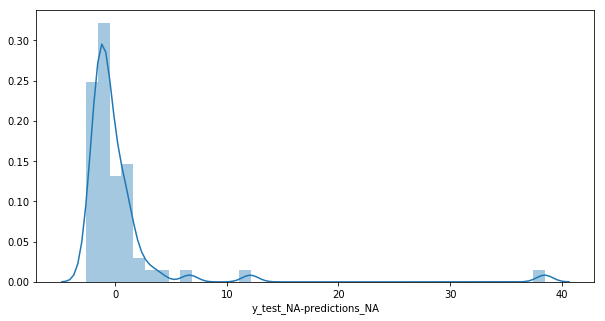

In [82]:
# Histograma de Residuos para a America do Norte
# A maior parte dos erros parece aproximar-se de um valor proximo do zero.

plt.figure(figsize=(10,5))
sns.distplot(y_test["y_NA"]-predictions_NA.flatten())
plt.xlabel("y_test_NA-predictions_NA")